In [ ]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt
import math
import sys
import os
import torch
from tqdm import tqdm
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli,\
    basis_T_to_pauli, reversed_str_bases_to_init_state, kernel_qaoa_Preserved, kernel_qaoa_X, kernel_flipped, get_optimizer

import seaborn as sns   
from copulas.multivariate import GaussianMultivariate
import joblib
import pickle

import time
cudaq.set_target("nvidia")
pd.set_option('display.width', 1000)
np.random.seed(50)
state = np.random.get_state()
# with open("rng_state.pkl", "wb") as f:
#     pickle.dump(state, f)
modes = ["X", "Preserving"]

# PIPELINE PARAMETERS
LOOP = 100
oversample_factor = 3
over_budget_bound = 1.0 # valid budget in [0, B * over_budget_bound]
min_P, max_P = 125, 250
hamiltonian_boost = 1000

# HYPER PARAMETERS
init_state_ratio = 0.1
TARGET_QUBIT = 6
N_ASSETS = 3
LAMB = 4 # Budget Penalty
Q = 0 # Volatility Weight

# num_init_bases = int(2**TARGET_QUBIT * init_state_ratio)
num_init_bases = 3

In [2]:
dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{num_init_bases}"
dir_path = f"./experiments/{dir_name}"
os.makedirs(f"{dir_path}", exist_ok=True)
# os.makedirs(f"{dir_path}/Preserving", exist_ok=True)
os.makedirs(f"{dir_path}/expectations_X", exist_ok=True)
os.makedirs(f"{dir_path}/expectations_Preserving", exist_ok=True)
os.makedirs(f"{dir_path}/iter_states", exist_ok=True)
report_col = ["Approximate_ratio", "MaxProb_ratio", "init_1_time", "init_2_time", "optim_time", "observe_time"]

# TODO
- init_ratio of feasible
- store each epoch loss
- Avg approx
- plot x: qubits, y: approx_ratio

(345, 2)


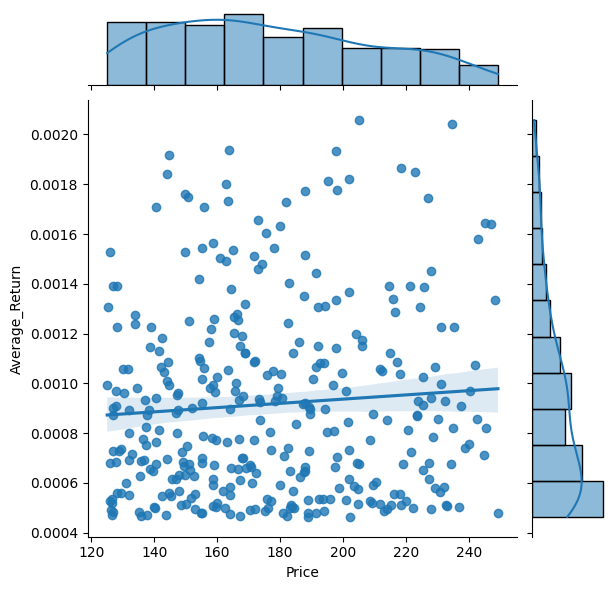

In [3]:
# with open("rng_state.pkl", "rb") as f:
#     state = pickle.load(f)
np.random.set_state(state)
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
# samples = GM_loaded.sample(50)
samples = GM_loaded.sample(int(N_ASSETS * LOOP * oversample_factor))
samples = samples[(samples["Price"] > min_P) & (samples["Price"] < max_P)]
# print(samples["Average_Return"].min(), samples["Average_Return"].max())
# print(samples["Price"].min(), samples["Price"].max())
print(samples.shape)
assert samples.shape[0] > N_ASSETS * LOOP, "Please increase the oversample factor to get more samples ;-;"
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
samples = samples.to_numpy()
plt.show()

In [4]:
def find_budget(target_qubit, P):
    n_assets = len(P)
    mi, ma = 125, max_P * ((1 << math.ceil(target_qubit/n_assets))-1)
    cou = 0
    mid = (mi + ma)/2
    while (N := np.sum(np.int32(np.floor(np.log2(mid/P))) + 1)) != target_qubit:
        if N < target_qubit:
            mi = mid
        else:
            ma = mid
        # print()
        mid = (mi + ma)/2
        cou += 1
        if cou > 100:
            assert False, "Cannot find budget for target qubit uwaaaaa (Should not happen, Please tell trusted adult lol)"
    return mid

# a = np.array([186, 195, 131])
# b = find_budget(22, a)
# print(b)
# print(np.int32(np.floor(np.log2(b/a))) + 1)

In [ ]:
def all_state_to_return(B, C, d_ret, d_p, over_budget_bound):
    qb = C.shape[1]
    l = np.zeros((1<<qb, qb))
    P = d_p @ C
    ret_C = (d_ret * d_p) @ C
    for i in range(1<<qb):
        s = bin(i)[2:].zfill(qb)
        ll = np.array(list(map(int, s)))
        l[i] = ll
    ss = l @ ret_C
    bud = l @ P
    return ss, bud <= B * over_budget_bound

def get_init_states(state_return, in_budget, num_init_bases, n_qubits):
    sorted_idx = np.argsort(-state_return)
    N = num_init_bases
    init_states = []
    cou = 0
    for i in sorted_idx:
        if in_budget[i]:
            init_states.append(bin(i)[2:].zfill(n_qubits))
            cou += 1
        if cou >= N:
            break
    return init_states

In [6]:
def write_df(df_dir, report_col, *data):
    df_new = pd.DataFrame(np.array(data).reshape(1, -1), columns=report_col)
    m_df = os.path.exists(df_dir)
    # print(df_dir)
    df_new.to_csv(df_dir, mode='a' if m_df else 'w', header=(not m_df), index=False)

In [7]:
def clip_df(df, restore_iter):
    assert restore_iter <= len(df), "restore_iter exceeds the number of iterations in the CSV file."
    df = df.iloc[:restore_iter]
    return df

In [8]:
CLEAR_EX_RESULT = True

restore_iter = 15
RESTORE_RUNTIME = False

if CLEAR_EX_RESULT:
    for curr_dir, dirs, files in os.walk(dir_path):
        for file in files:
            os.remove(os.path.join(curr_dir, file))

if RESTORE_RUNTIME:
    for mode in modes:
        df = pd.read_csv(f"./{dir_path}/{mode}.csv")
        df = clip_df(df, restore_iter)
        df.to_csv(f"{dir_path}/{mode}.csv", index=False)

    with open(f"{dir_path}/iter_states/{str(restore_iter).zfill(4)}.pkl", "rb") as f:
        state = pickle.load(f)
    np.random.set_state(state)

# Be careful!! CSV writing is in append mode

In [ ]:
start_iter = restore_iter if RESTORE_RUNTIME else 0
pbar = tqdm(range(start_iter, LOOP))
for i in pbar:
    with open(f"{dir_path}/iter_states/{str(i).zfill(4)}.pkl", "wb") as f:
        pickle.dump(np.random.get_state(), f)

    pbar.set_description("global:init_1")
    st = time.time()

    P = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 0]
    ret = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 1]
    # print(P)
    # print(ret)
    
    # P = np.array([195.27, 183.26, 131.3])
    # ret = np.array([0.00107, 0.00083, 0.00071])
    cov = np.random.rand(N_ASSETS, N_ASSETS)
    cov += cov.T
    q = 0 # Volatility Weight
    B = find_budget(TARGET_QUBIT, P)
    # print(B)
    # break
    # B = 270
    P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)
    state_return, in_budget = all_state_to_return(B, C, ret, P, over_budget_bound)
    init_state = get_init_states(state_return, in_budget, num_init_bases, n_qubit)

    init_1_time = time.time() - st
    # print(f"initial: {init_1_time*1000:.2f} ms.")

    for mode in modes:
        pbar.set_description(f"{mode}:init_2")
        st = time.time()
        lamb = LAMB if mode == "X" else 0 # Budget Penalty

        QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
        H = qubo_to_ising(QU, lamb).canonicalize() * (1 if mode == "X" else hamiltonian_boost)
        idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use = process_ansatz_values(H)

        kernel_qaoa_use = kernel_qaoa_X if mode == "X" else kernel_qaoa_Preserved

        idx = 3
        layer_count = 5
        parameter_count = layer_count * 2
        optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)
        optimizer.max_iterations = 1000

        if mode == "X":
            ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)
            init_2_time = time.time() - st
            # print(f"init for {mode}: {init_2_time*1000:.2f} ms.")
        else:
            n_bases = len(init_state)
            # print("n_bases:", n_bases)
            T = np.zeros((n_bases, n_bases), dtype=np.float32)
            T[:-1, 1:] += np.eye(n_bases - 1, dtype=np.float32)
            T[1:, :-1] += np.eye(n_bases - 1, dtype=np.float32)
            T[0, -1] = T[-1, 0] = 1.0
            # print(T)
            mixer_s, mixer_c = basis_T_to_pauli(init_state, T, n_qubit)
            init_bases = reversed_str_bases_to_init_state(init_state, n_qubit)
            ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)
            init_2_time = time.time() - st
            # print(f"Init for {mode}: {init_2_time*1000:.2f} ms.")
        # print(cudaq.draw(kernel_qaoa_use, [0.5]*4, *ansatz_fixed_param[:1], 1, *ansatz_fixed_param[2:]))

        pbar.set_description(f"{mode}:optim")
        st = time.time()
        expectations = []
        def cost_func(parameters):
            # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
            return cudaq.observe(kernel_qaoa_use, H, parameters, *ansatz_fixed_param).expectation()

        def objective(parameters):
            expectation = cost_func(parameters)
            expectations.append(expectation)
            return expectation

        def objective_grad_cuda(parameters):
            expectation = cost_func(parameters)
            expectations.append(expectation)

            gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

            return expectation, gradient

        objective_func = objective_grad_cuda if FIND_GRAD else objective

        optimal_expectation, optimal_parameters = optimizer.optimize(
            dimensions=parameter_count, function=objective_func)
        np.save(f"{dir_path}/expectations_{mode}/expectations_{i}.npy", np.array(expectations))
        optim_time = time.time() - st
        # print(f"Optimization for {mode}: {optim_time*1000:.2f} ms.")
        
        pbar.set_description(f"{mode}:observe")
        st = time.time()
        result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
        idx_r_best = np.argmax(np.abs(result))
        idx_best = bin(idx_r_best)[2:].zfill(n_qubit)[::-1]

        result_r = cudaq.get_state(kernel_flipped, result, TARGET_QUBIT)
        prob = np.abs(result_r)**2

        approx_ratio = (prob * (state_return * in_budget)).sum() / state_return[int(init_state[0], 2)]
        maxprob_ratio = state_return[int(idx_best, 2)] / state_return[int(init_state[0], 2)] if in_budget[int(idx_best, 2)] else 0.0

        observe_time = time.time() - st

        write_df(f"{dir_path}/{mode}.csv", report_col,
                    approx_ratio, maxprob_ratio, init_1_time, init_2_time, optim_time, observe_time)
        
        # break
    # break
        

        # print(f"Observation: {observe_time*1000:.2f} ms.")

        # print(idx_best, init_state[0])
        # print(state_return[int(idx_best, 2)], in_budget[int(idx_best, 2)], state_return[int(init_state[0], 2)], in_budget[int(init_state[0], 2

        # approx_ratio = state_return[int(idx_best, 2)] / state_return[int(init_state[0], 2)] if in_budget[int(idx_best, 2)] else 0.0
        # write_df(f"{dir_path}/{mode}.csv", 
        #             approx_ratio, init_1_time, init_2_time, optim_time, observe_time)
    


Preserving:observe: 100%|██████████| 100/100 [06:19<00:00,  3.80s/it]


In [10]:
df_X = pd.read_csv(f"{dir_path}/X.csv")
df_P = pd.read_csv(f"{dir_path}/Preserving.csv")

approx_X = df_X["Approximate_ratio"].mean()
approx_P = df_P["Approximate_ratio"].mean()
print(f"Approximate ratio for X: {approx_X:.4f}, Preserving: {approx_P:.4f}")

maxprob_X = df_X["MaxProb_ratio"].mean()
maxprob_P = df_P["MaxProb_ratio"].mean()
print(f"MaxProb ratio for X: {maxprob_X:.4f}, Preserving: {maxprob_P:.4f}")

init_1_time_X = df_X["init_1_time"].mean()
init_2_time_X = df_X["init_2_time"].mean()
optim_time_X = df_X["optim_time"].mean()
observe_time_X = df_X["observe_time"].mean()

init_1_time_P = df_P["init_1_time"].mean()
init_2_time_P = df_P["init_2_time"].mean()
optim_time_P = df_P["optim_time"].mean()
observe_time_P = df_P["observe_time"].mean()

print(f"Init 1 time for X: {init_1_time_X*1000:.2f} ms, Preserving: {init_1_time_P*1000:.2f} ms")
print(f"Init 2 time for X: {init_2_time_X*1000:.2f} ms, Preserving: {init_2_time_P*1000:.2f} ms")
print(f"Optim time for X: {optim_time_X*1000:.2f} ms, Preserving: {optim_time_P*1000:.2f} ms")
print(f"Observe time for X: {observe_time_X*1000:.2f} ms, Preserving: {observe_time_P*1000:.2f} ms")

col_result = ["Mode"] + report_col
df_result = pd.DataFrame(columns=col_result)
df_result.loc[0] = ["X", approx_X, maxprob_X, init_1_time_X, init_2_time_X, optim_time_X, observe_time_X]
df_result.loc[1] = ["Preserving", approx_P, maxprob_P, init_1_time_P, init_2_time_P, optim_time_P, observe_time_P]
df_result.to_csv(f"{dir_path}/result.csv", index=False)

Approximate ratio for X: 0.5130, Preserving: 0.9430
MaxProb ratio for X: 0.3874, Preserving: 1.0000
Init 1 time for X: 0.18 ms, Preserving: 0.18 ms
Init 2 time for X: 0.44 ms, Preserving: 0.58 ms
Optim time for X: 2968.03 ms, Preserving: 821.76 ms
Observe time for X: 1.49 ms, Preserving: 2.23 ms


In [11]:
assert False

AssertionError: 

In [ ]:
read_report = pd.read_csv(f"./experiments/exp_Q6_A3_L1.5_q0_B6/result.csv")
print(read_report)

         Mode  Approximate_ratio  init_1_time  init_2_time  optim_time  observe_time
0           X           0.251899      0.00021     0.000638    3.733740      0.001384
1  Preserving           0.949699      0.00021     0.004031    0.162099      0.007006


In [ ]:
a = torch.arange(10)
aa = torch.tensor(a, device='cuda')

ab = torch.abs(aa)
am = torch.argmax(ab)

/tmp/ipykernel_3877/3788695641.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa = torch.tensor(a, device='cuda')


In [ ]:
a = np.zeros((1<<25), dtype=np.complex64)

In [ ]:
# for i in result.getTensors():
#     print(i.)

In [ ]:
st = time.time()
# result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
torch.argmax(torch.abs(torch.tensor(np.array(result), device='cuda')))
# am = np.argmax(np.abs(a))
# am = np.argmax(np.abs(result))

ed = time.time() - st
print(f"Observation: {ed*1000:.2f} ms.")

Observation: 0.49 ms.


In [ ]:
# import numpy as np
# import torch as th
# c=np.random.rand(10000000).astype(np.float32) # cpu version
# g=th.tensor(c).to(device='cuda:0')             # gpu version
# %timeit -n 10 np.median(c,axis=0)    
# %timeit -n 10 np.sort(c,axis=0)[1]      
# %timeit -n 10 th.median(g,dim=0).values 
# %timeit -n 10 th.sort(g,dim=0).values[1]

59.8 ms ± 111 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

587 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

246 μs ± 591 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

41.9 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)